Dataset shape: (604, 5)
   time  bandwidth_utilization_Mbps  packet_loss_count  packet_delivery_ratio  \
0     1                    0.000000               7636               0.000000   
1     2                    0.000000                636               0.000000   
2     3                    0.335872               2816               0.238372   
3     4                    0.876544               4167               0.421260   
4     5                    0.000000                636               0.000000   

   congestion_ratio  
0           16.1780  
1           15.9000  
2           16.3721  
3           16.4055  
4           15.9000  

Missing values:
time                          0
bandwidth_utilization_Mbps    0
packet_loss_count             0
packet_delivery_ratio         0
congestion_ratio              0
dtype: int64

Basic statistics:
             time  bandwidth_utilization_Mbps  packet_loss_count  \
count  604.000000                  604.000000         604.000000   
mean   302.5

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


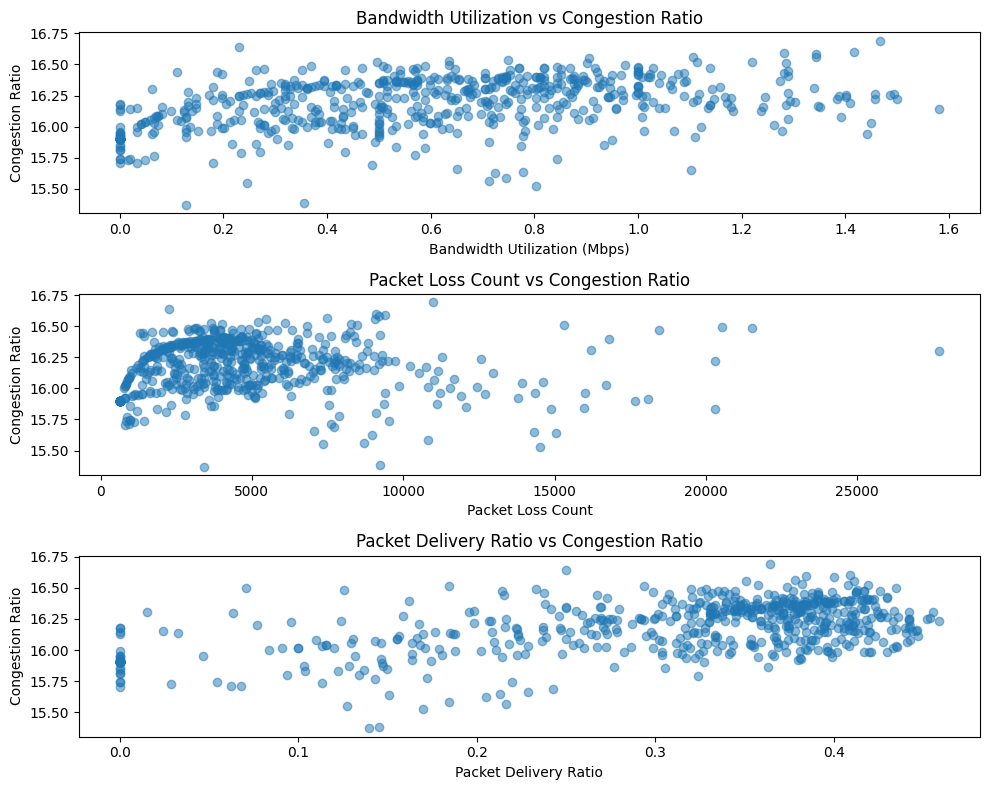

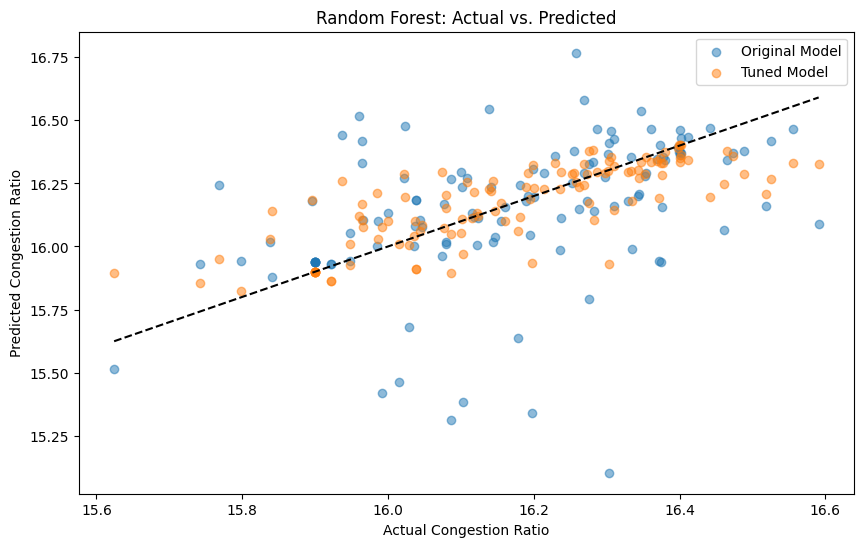

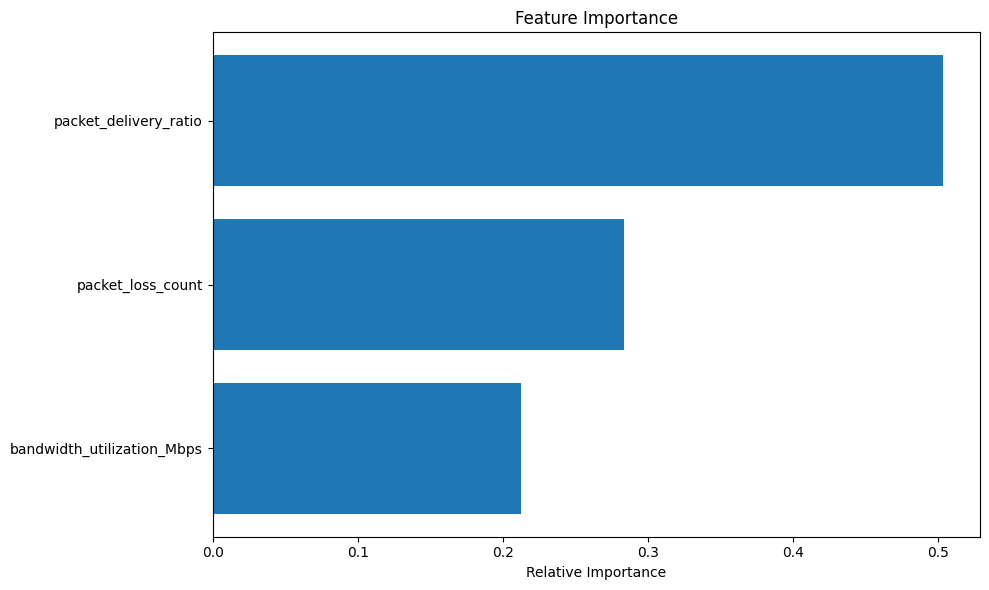

In [ ]:
"""
ML Model Development for Adaptive Load Balancing in Wireless Mesh Networks
This script develops and evaluates various machine learning models for predicting
network congestion in wireless mesh networks.
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import time

# Load the simulation data
data = pd.read_csv('simulation_data.csv')
print(f"Dataset shape: {data.shape}")
print(data.head())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(data.describe())

# Correlation analysis
correlation_matrix = data.corr()
print("\nCorrelation with congestion_ratio:")
print(correlation_matrix['congestion_ratio'].sort_values(ascending=False))

# Plot correlation between features and target
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.scatter(data['bandwidth_utilization_Mbps'], data['congestion_ratio'], alpha=0.5)
plt.title('Bandwidth Utilization vs Congestion Ratio')
plt.xlabel('Bandwidth Utilization (Mbps)')
plt.ylabel('Congestion Ratio')

plt.subplot(3, 1, 2)
plt.scatter(data['packet_loss_count'], data['congestion_ratio'], alpha=0.5)
plt.title('Packet Loss Count vs Congestion Ratio')
plt.xlabel('Packet Loss Count')
plt.ylabel('Congestion Ratio')

plt.subplot(3, 1, 3)
plt.scatter(data['packet_delivery_ratio'], data['congestion_ratio'], alpha=0.5)
plt.title('Packet Delivery Ratio vs Congestion Ratio')
plt.xlabel('Packet Delivery Ratio')
plt.ylabel('Congestion Ratio')
plt.tight_layout()
plt.savefig('correlation_plots.png')

# Prepare data for modeling
X = data[['bandwidth_utilization_Mbps', 'packet_loss_count', 'packet_delivery_ratio']]
y = data['congestion_ratio']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use in the integration phase
joblib.dump(scaler, 'scaler.pkl')

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Neural Network': MLPRegressor(max_iter=1000, random_state=42)
}

# Dictionary to store results
results = {}
best_model = None
best_score = -float('inf')

# Train and evaluate each model
for name, model in models.items():
    start_time = time.time()

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    training_time = time.time() - start_time

    # Store results
    results[name] = {
        'MSE': mse,
        'R2': r2,
        'Training Time': training_time
    }

    # Update best model
    if r2 > best_score:
        best_score = r2
        best_model = name

    print(f"\n{name} Results:")
    print(f"Mean Squared Error: {mse:.6f}")
    print(f"R-squared: {r2:.6f}")
    print(f"Training Time: {training_time:.2f} seconds")

# Print summary
print("\nModel Comparison Summary:")
for name, metrics in results.items():
    print(f"{name}: MSE={metrics['MSE']:.6f}, R²={metrics['R2']:.6f}, Time={metrics['Training Time']:.2f}s")

print(f"\nBest performing model: {best_model} with R² = {results[best_model]['R2']:.6f}")

# Hyperparameter tuning for the best model
print(f"\nFine-tuning {best_model}...")

if best_model == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    best_model_instance = RandomForestRegressor(random_state=42)
elif best_model == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5]
    }
    best_model_instance = GradientBoostingRegressor(random_state=42)
elif best_model == 'Neural Network':
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    best_model_instance = MLPRegressor(max_iter=1000, random_state=42)
elif best_model == 'Decision Tree':
    param_grid = {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    }
    best_model_instance = DecisionTreeRegressor(random_state=42)
else:  # For linear models
    param_grid = {
        'fit_intercept': [True, False],
        'normalize': [True, False]
    }
    if best_model == 'Ridge Regression':
        param_grid['alpha'] = [0.01, 0.1, 1.0, 10.0]
        best_model_instance = Ridge()
    elif best_model == 'Lasso Regression':
        param_grid['alpha'] = [0.01, 0.1, 1.0, 10.0]
        best_model_instance = Lasso()
    else:  # Linear Regression
        best_model_instance = LinearRegression()

# Perform grid search
grid_search = GridSearchCV(best_model_instance, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.6f}")

# Evaluate the tuned model
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test_scaled)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"\nTuned {best_model} Results:")
print(f"Mean Squared Error: {mse_tuned:.6f}")
print(f"R-squared: {r2_tuned:.6f}")

# Compare original vs. tuned model predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Original Model')
plt.scatter(y_test, y_pred_tuned, alpha=0.5, label='Tuned Model')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Congestion Ratio')
plt.ylabel('Predicted Congestion Ratio')
plt.title(f'{best_model}: Actual vs. Predicted')
plt.legend()
plt.savefig('model_comparison.png')

# Feature importance for tree-based models
if best_model in ['Decision Tree', 'Random Forest', 'Gradient Boosting']:
    feature_importance = tuned_model.feature_importances_
    features = X.columns
    indices = np.argsort(feature_importance)

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importance')
    plt.barh(range(len(indices)), feature_importance[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')

    print("\nFeature Importance:")
    for i, feature in enumerate(features):
        print(f"{feature}: {feature_importance[i]:.4f}")

# Save the best model
joblib.dump(tuned_model, 'best_congestion_model.pkl')
print("\nBest model saved as 'best_congestion_model.pkl'")

# Sample prediction function for later integration
def predict_congestion(bandwidth_utilization, packet_loss, packet_delivery_ratio):
    """
    Predict network congestion based on input metrics

    Args:
        bandwidth_utilization (float): Bandwidth utilization in Mbps
        packet_loss (int): Number of packet losses
        packet_delivery_ratio (float): Packet delivery ratio

    Returns:
        float: Predicted congestion ratio
    """
    # Create feature array
    features = np.array([[bandwidth_utilization, packet_loss, packet_delivery_ratio]])

    # Scale features
    scaled_features = scaler.transform(features)

    # Make prediction
    prediction = tuned_model.predict(scaled_features)[0]

    return prediction

# Example usage:
test_prediction = predict_congestion(0.5, 5000, 0.3)
print(f"\nSample prediction for bandwidth=0.5Mbps, packet_loss=5000, PDR=0.3:")
print(f"Predicted congestion ratio: {test_prediction:.4f}")

print("\nML model development phase completed successfully.")